Note: you may need to restart the kernel to use updated packages.


Fetching data for 2015...
Fetching data for 2016...
Fetching data for 2017...
Fetching data for 2018...
Fetching data for 2019...
Fetching data for 2020...
Fetching data for 2021...
Fetching data for 2022...
Fetching data for 2023...
Fetching data for 2024...
✅ Data successfully saved to 'pune_weather_2010_2024.csv'
        Date  ALLSKY_SFC_SW_DWN    T2M   RH2M  WS2M  PRECTOTCORR     PS  \
0 2015-01-01             2.1614  15.00  44.34  1.09         0.00  99.03   
1 2015-01-02             0.8503  14.79  62.46  1.15         7.24  99.12   
2 2015-01-03             1.3795  14.60  75.79  0.62         3.34  99.10   
3 2015-01-04             2.1077  13.10  64.43  1.82         0.00  99.22   
4 2015-01-05             3.5978  12.57  46.47  3.20         0.00  98.98   

   CLRSKY_SFC_SW_DWN  ALLSKY_KT  Year  Month  DayOfYear  Weekday  
0             3.4766       0.37  2015      1          1        3  
1             3.5364       0.15  2015      1          2        4  
2             3.5808       0.2

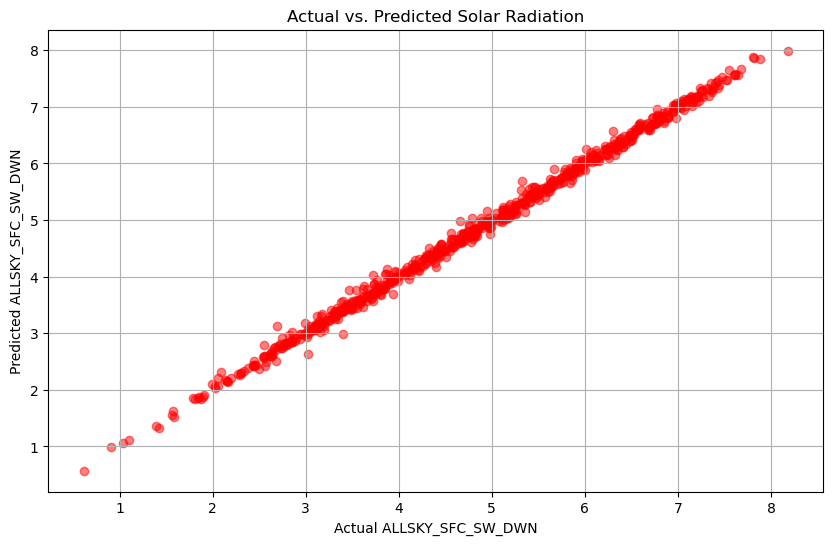

In [1]:
import requests
import pandas as pd

# 1. Set location (Pune) and parameters
latitude = 28.7041
longitude = 77.1025
parameters = (
    "ALLSKY_SFC_SW_DWN,"
    "T2M,"
    "RH2M,"
    "WS2M,"
    "PRECTOTCORR,"
    "PS,"
    "CLRSKY_SFC_SW_DWN,"
    "ALLSKY_KT"
)

# 2. Create a list of years (2015 to 2025)
years = list(range(2015, 2025))

# 3. Create an empty list to store each year’s data
full_data = []

# 4. Loop over each year and fetch data
for year in years:
    start_date = f"{year}0101"
    end_date = f"{year}1231"

    url = (
        f"https://power.larc.nasa.gov/api/temporal/daily/point?"
        f"parameters={parameters}&"
        f"start={start_date}&end={end_date}&"
        f"latitude={latitude}&longitude={longitude}&"
        f"community=RE&format=JSON"
    )

    print(f"Fetching data for {year}...")
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        # Extract the parameter data
        df = pd.DataFrame(data['properties']['parameter'])
        # The dates are the index, convert them to datetime objects
        df.index = pd.to_datetime(df.index, format='%Y%m%d')
        # Rename the index to 'Date'
        df.index.name = 'Date'
        # Reset the index to make 'Date' a column
        df = df.reset_index()
        full_data.append(df)
    else:
        print(f"Failed to fetch data for {year} — Status code: {response.status_code}")

# 5. Combine all yearly data into one DataFrame
final_df = pd.concat(full_data, ignore_index=True)

# 6. Add time-based features for ML
final_df['Year'] = final_df['Date'].dt.year
final_df['Month'] = final_df['Date'].dt.month
final_df['DayOfYear'] = final_df['Date'].dt.dayofyear
final_df['Weekday'] = final_df['Date'].dt.dayofweek

# 7. Save final dataset to CSV
final_df.to_csv("pune_weather_2010_2024.csv", index=False)

# 8. Preview result
print("✅ Data successfully saved to 'pune_weather_2010_2024.csv'")
print(final_df.head())

# Print the shape of the final DataFrame
rows, columns = final_df.shape
print(f"Number of rows: {rows}")
print(f"Number of columns: {columns}")


# X = input features, y = target
features = ['T2M', 'RH2M', 'WS2M', 'PRECTOTCORR', 'PS', 'CLRSKY_SFC_SW_DWN', 'ALLSKY_KT', 'Month', 'DayOfYear', 'Weekday']
X = final_df[features]
y = final_df['ALLSKY_SFC_SW_DWN']  # Target: actual solar radiation


# Check for missing values
print(X.isnull().sum())
print(y.isnull().sum())

# Fill or drop (we'll fill with mean for simplicity)
X = X.fillna(X.mean())
y = y.fillna(y.mean())


from sklearn.model_selection import train_test_split

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np # Import numpy

# Create the model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
# Calculate RMSE by taking the square root of the mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Score on training set
y_train_pred = model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"Train R²: {r2_train:.4f}, Train RMSE: {rmse_train:.4f}")


print(f"✅ R2 Score: {r2:.4f}")
print(f"✅ RMSE: {rmse:.4f}")

from sklearn.model_selection import cross_val_score
model = XGBRegressor(n_estimators=100, random_state=42)
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("Cross-validation R² scores:", scores)
print("Average CV R²:", scores.mean())


import matplotlib.pyplot as plt

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='red') # Changed color to red
plt.xlabel("Actual ALLSKY_SFC_SW_DWN")
plt.ylabel("Predicted ALLSKY_SFC_SW_DWN")
plt.title("Actual vs. Predicted Solar Radiation")
plt.grid(True)
plt.show()

In [2]:
import pickle

In [3]:
with open('solar_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("✅ Model saved as 'solar_model.pkl'")

✅ Model saved as 'solar_model.pkl'
